<Axes: xlabel='residual sugar', ylabel='pH'>

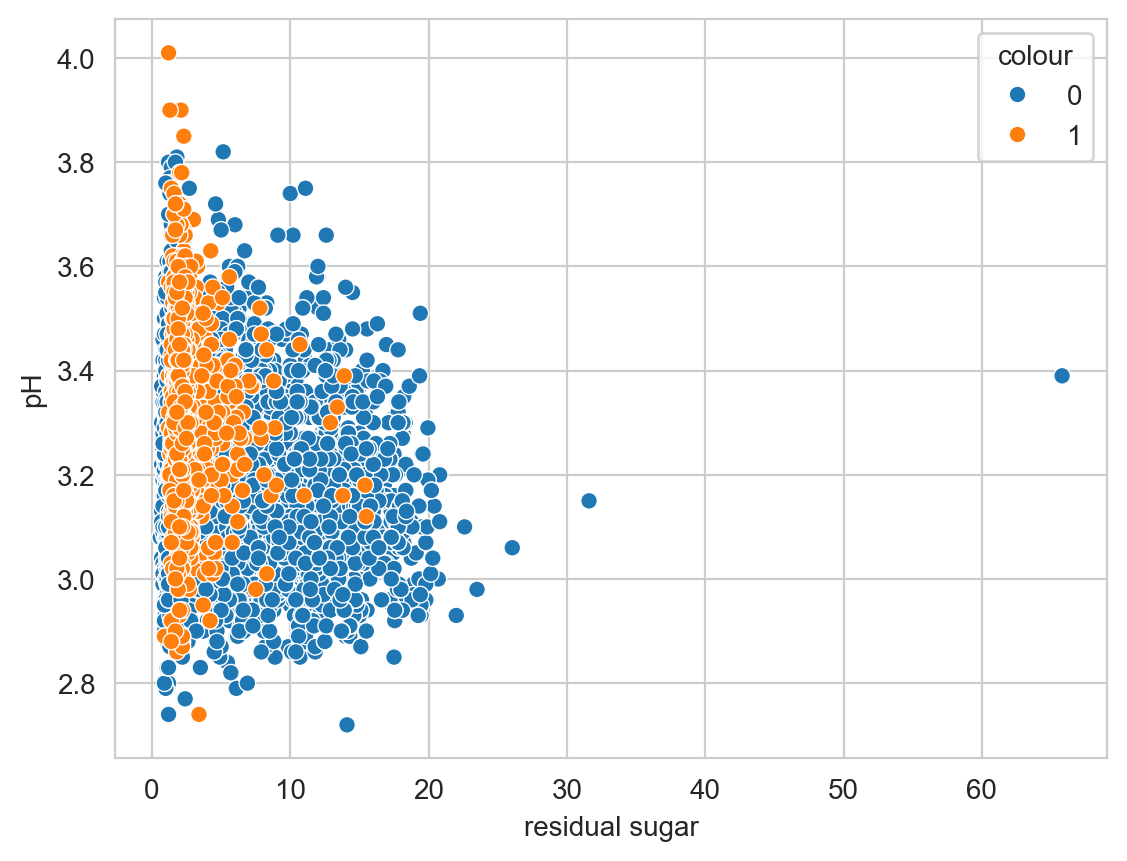

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

wine_data_all = pd.read_csv("winequality-all.csv")

wine_data_all.head()

'''
Units for columns:
Fixed acidity (g(tararic acid) / dm^3)
Volatile acidity (g(acetic acid) / dm^3)
Citric acid (g / dm^3)
Residual sugar (g / dm^3)
Chlorides (g(sodium chloride)/dm^3)
Free sulfur dioxide (mg / dm^3)
Total sulfur dioxide (mg / dm^3)
Density (g / cm^3)
pH (dimensionless)
Sulphates (g(KSO_4) / dm^3)
Alcohol (vol.%)
Quality (subjective score between 0 and 10, 10 being the best and 0 being the worst)
Colour (Dummy variable where 1 is red and 0 is white
'''

wine_data_all.groupby('colour').describe()
def filter_drop_column(df : pd.DataFrame,condition: bool, column: str) -> pd.DataFrame:
    filtered_df = df[condition]
    return filtered_df.drop(column, axis=1)

sns.scatterplot(data=wine_data_all,x="residual sugar",y="pH", hue="colour")



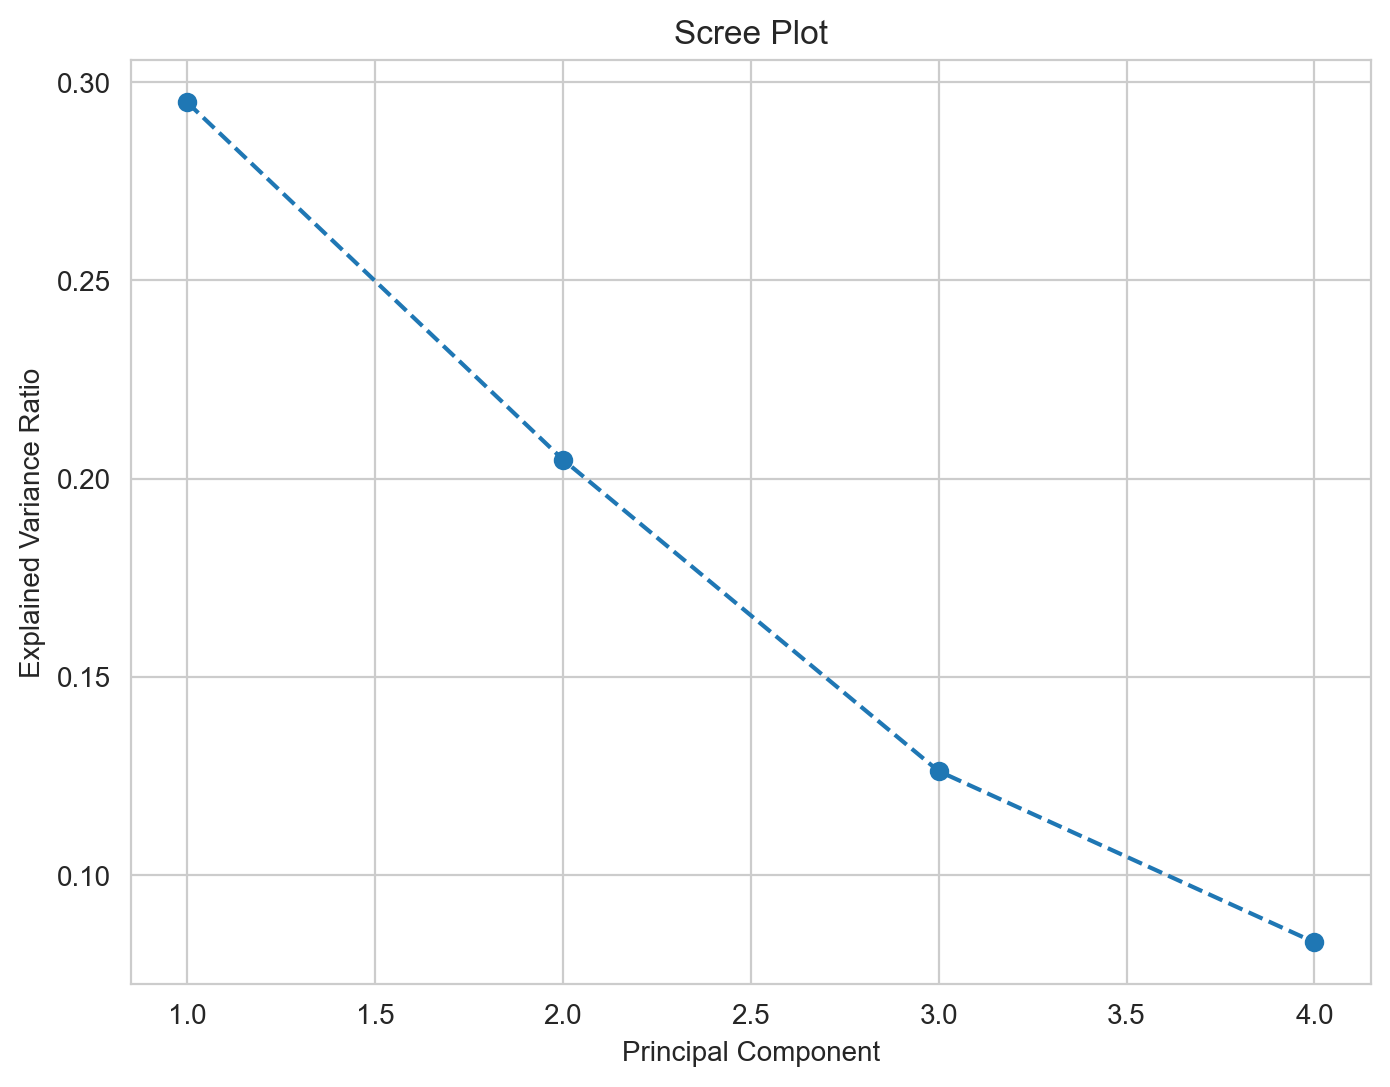

array([0.29492412, 0.20484445, 0.12627433, 0.08311596])

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca = PCA(n_components=4)
scaler = StandardScaler()
pipeline = make_pipeline(scaler,pca)
fit = pipeline.fit(wine_data_all)
explained_variance = pca.explained_variance_ratio_

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

loadings = pca.components_.T

# Create a DataFrame with labeled columns
num_components = loadings.shape[1]  # Number of PCA components

# Create a DataFrame with columns labeled as "PCA 1," "PCA 2," ...
pca_columns = [f'PCA {i + 1}' for i in range(num_components)]
pca_df = pd.DataFrame(loadings, columns=pca_columns)

# Add the corresponding feature names as row labels if needed
pca_df.index = wine_data_all.columns

# Display the PCA component loadings
pca_df

pca.explained_variance_ratio_

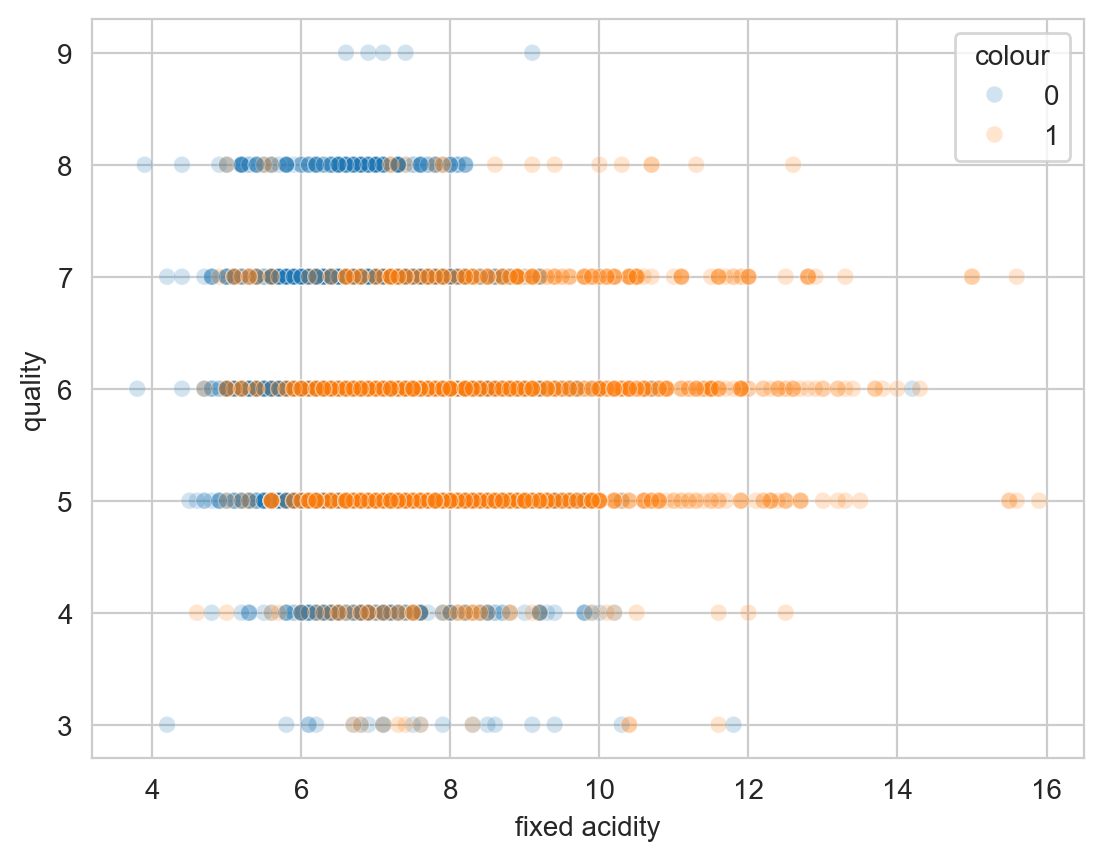

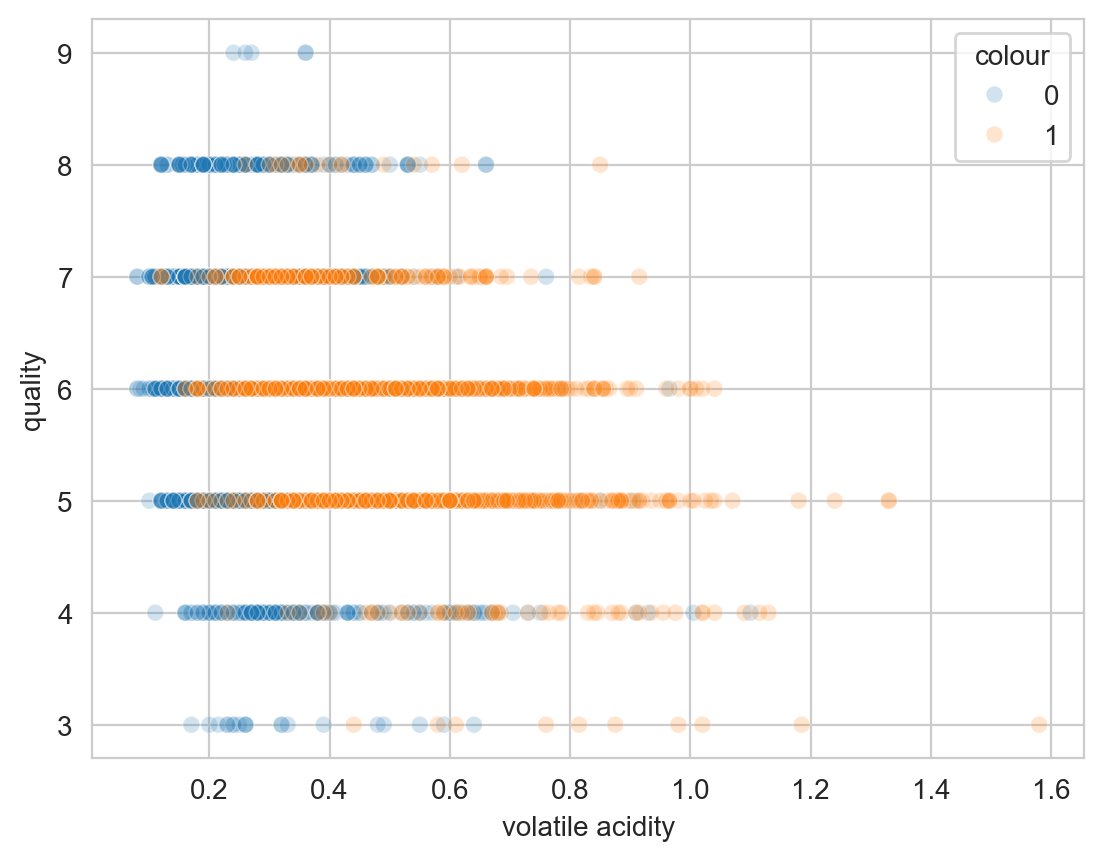

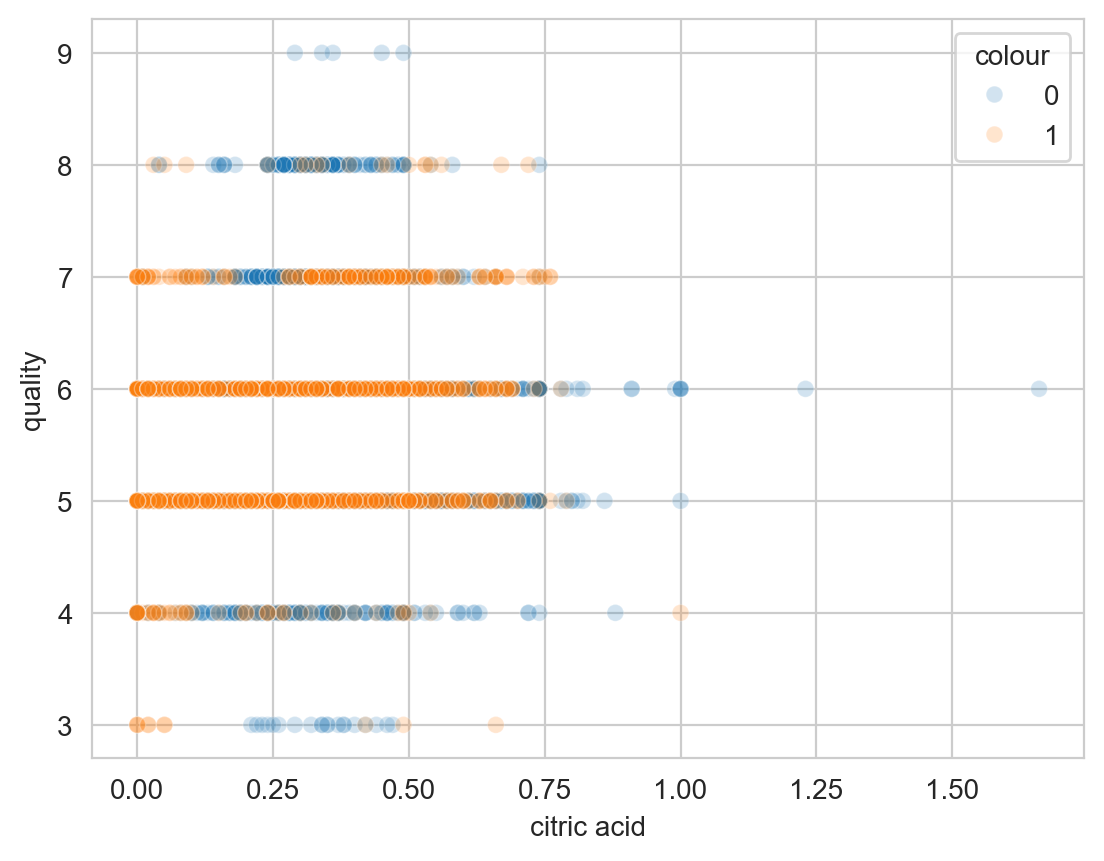

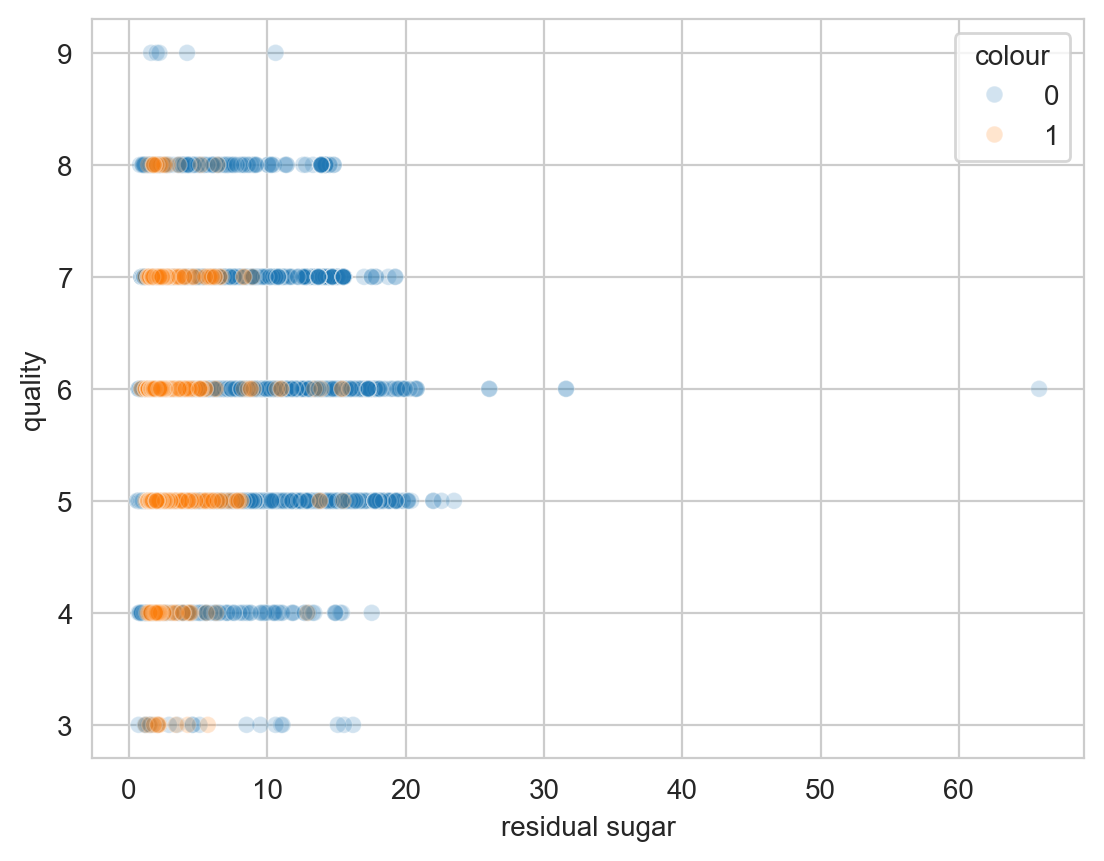

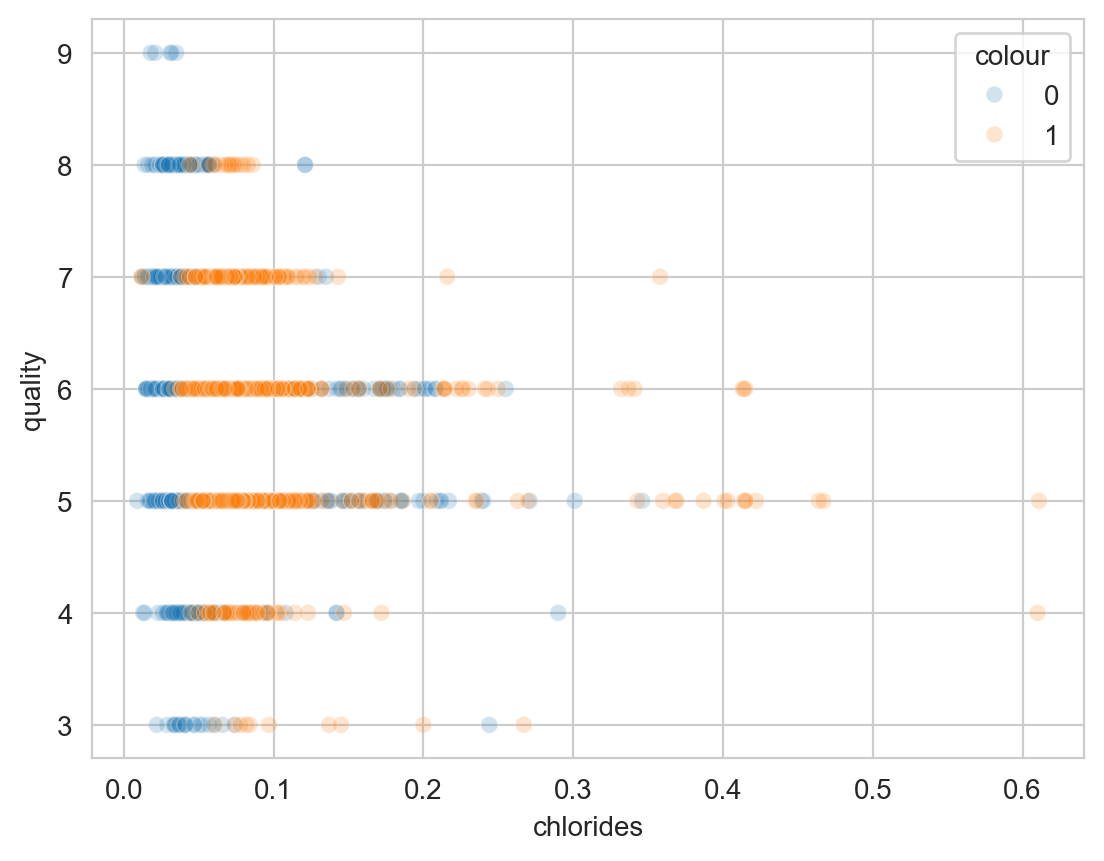

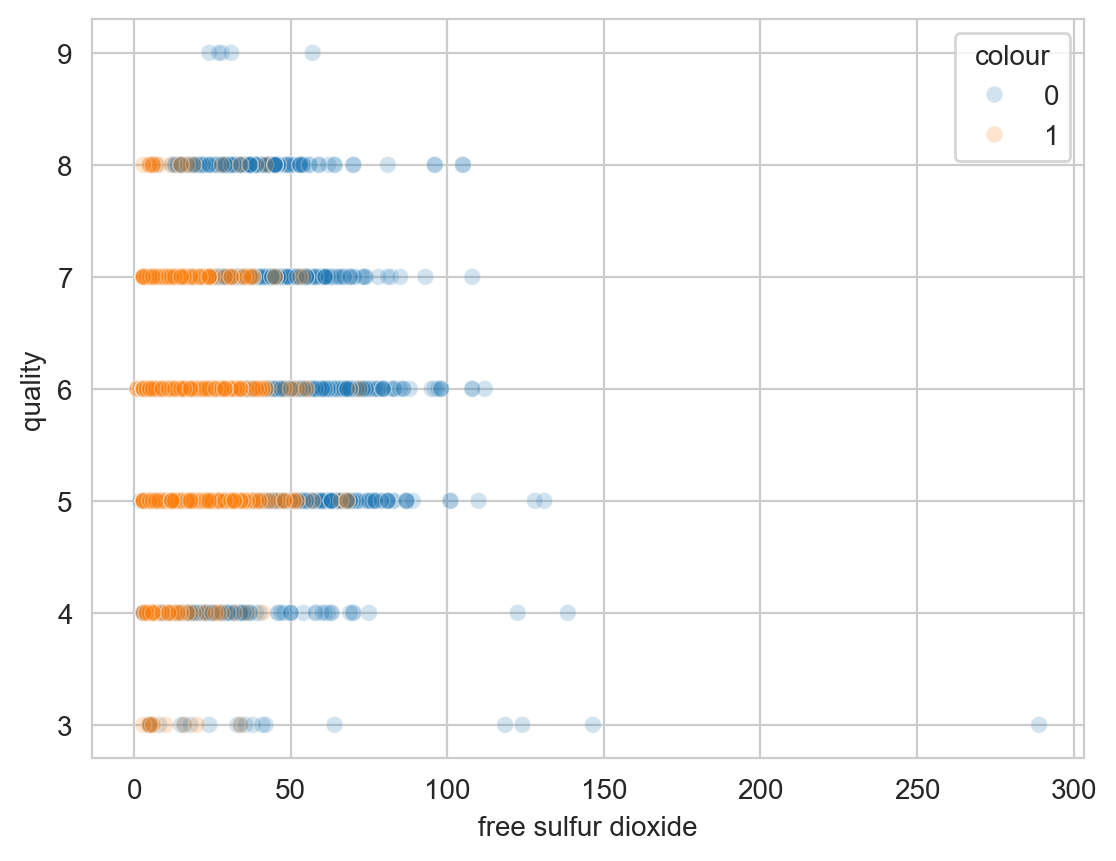

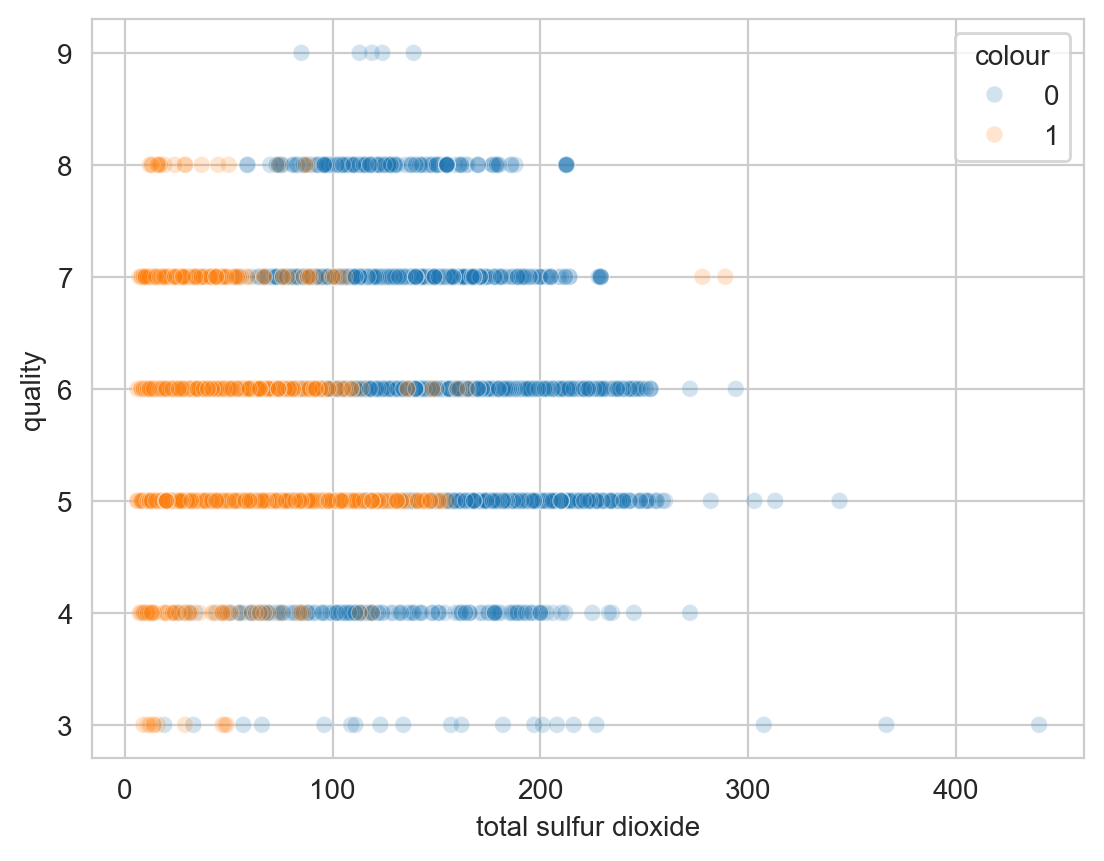

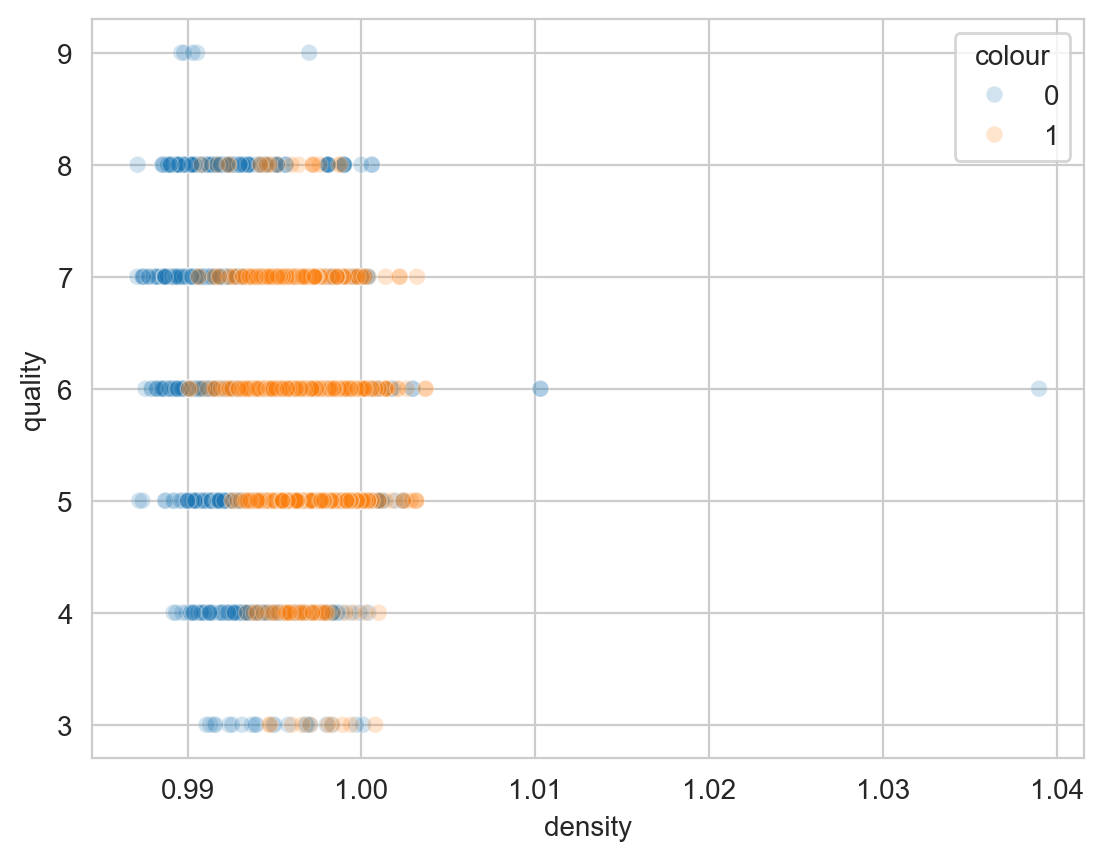

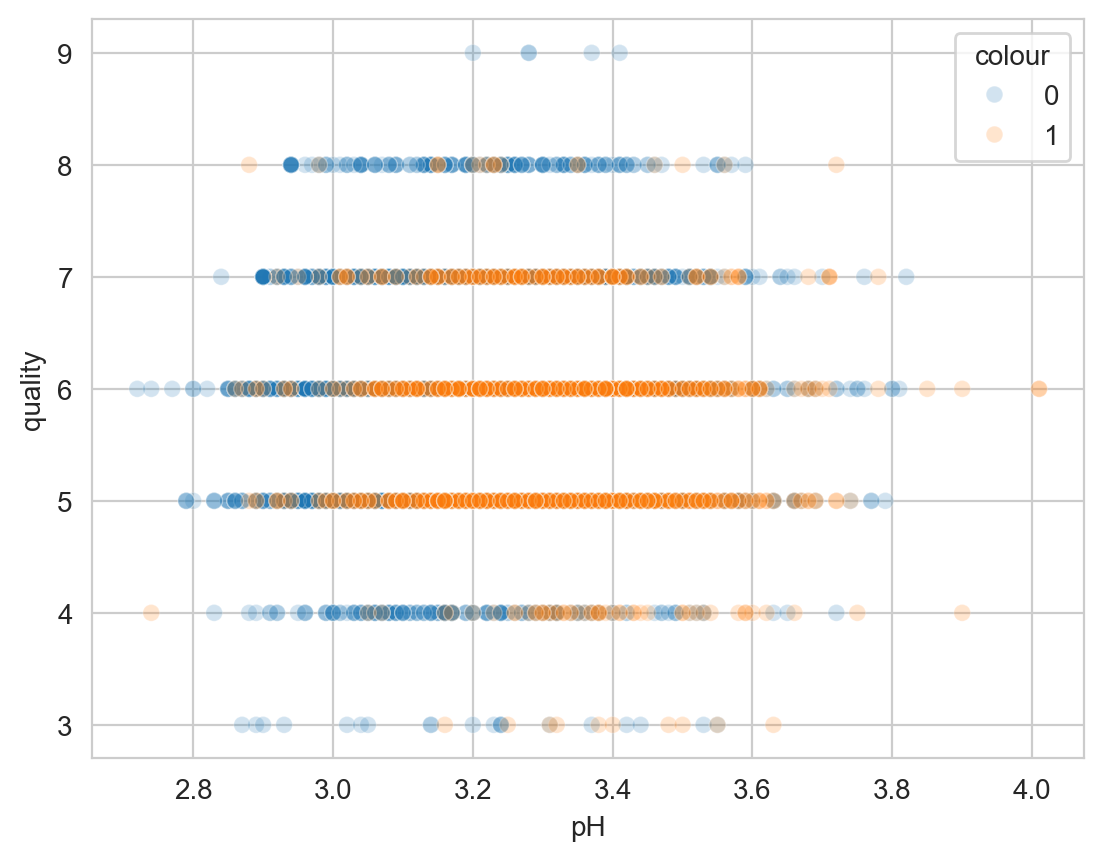

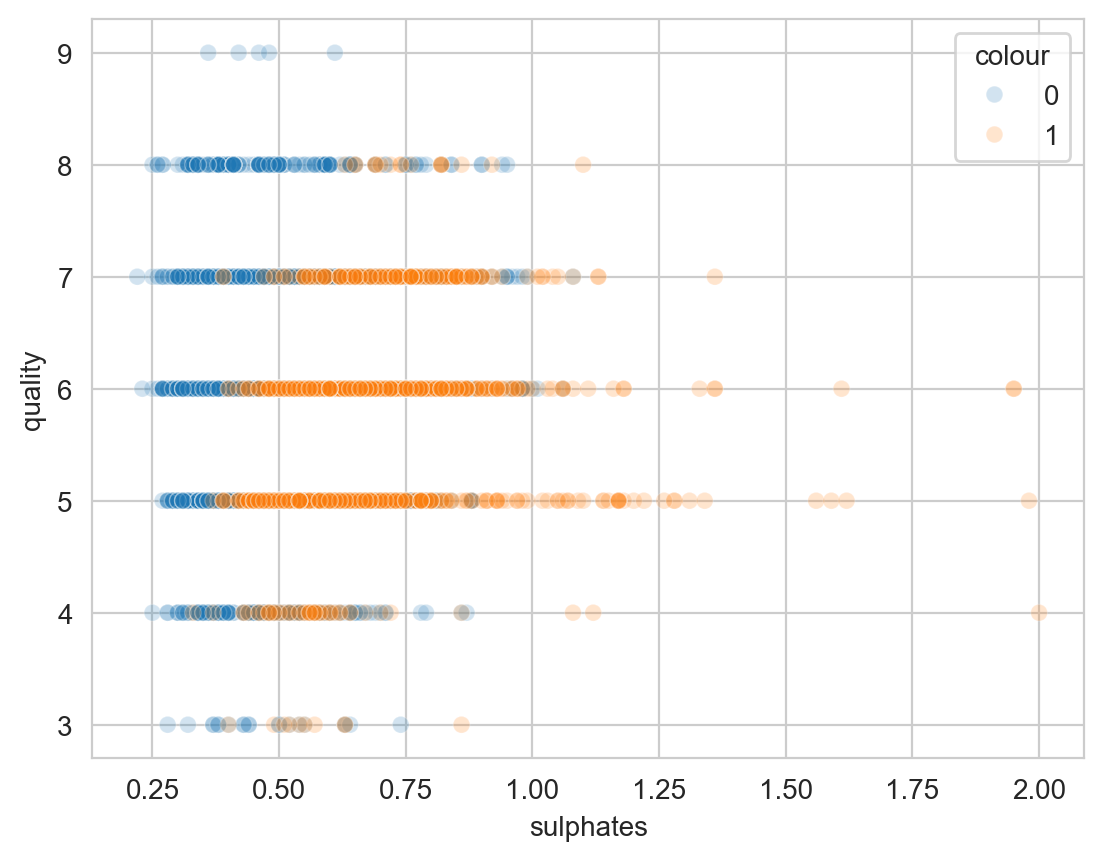

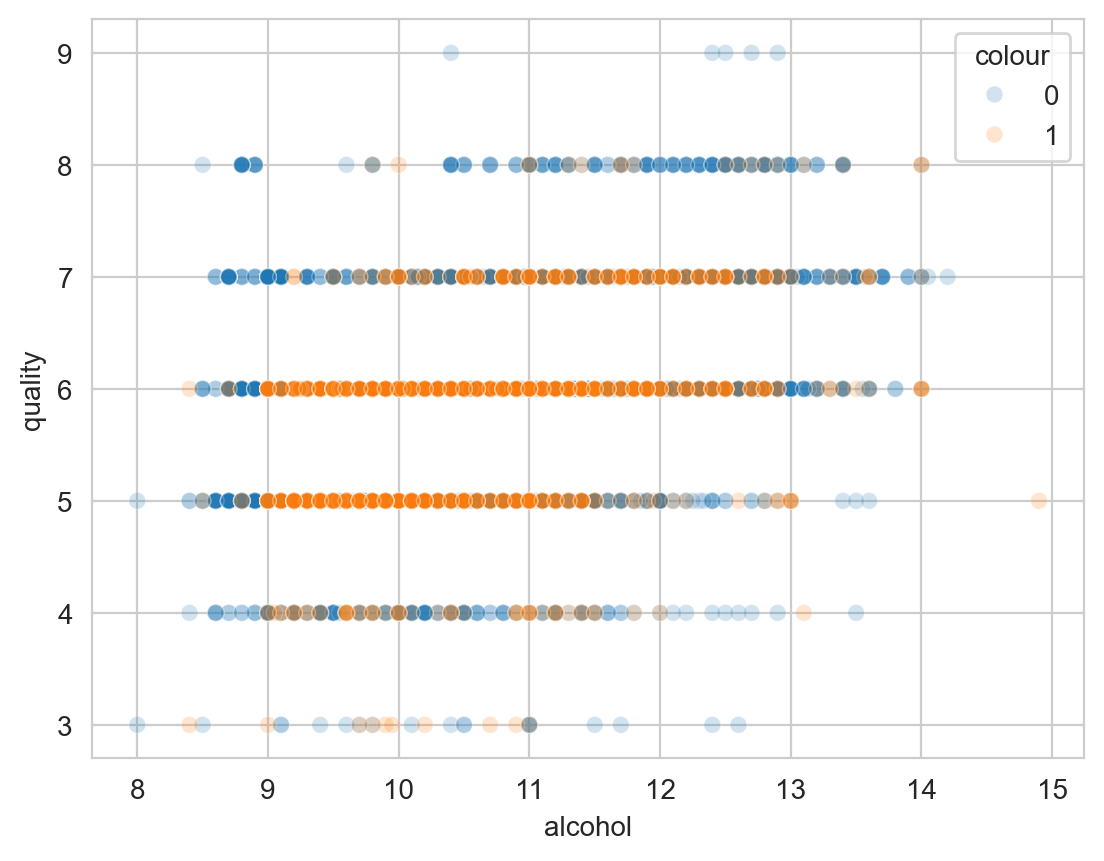

In [134]:
wine_data_all.columns.tolist()

for col in wine_data_all.columns.tolist()[:-2]:
    sns.scatterplot(data=wine_data_all,x=col,y="quality",hue="colour",alpha=0.2)
    plt.show()

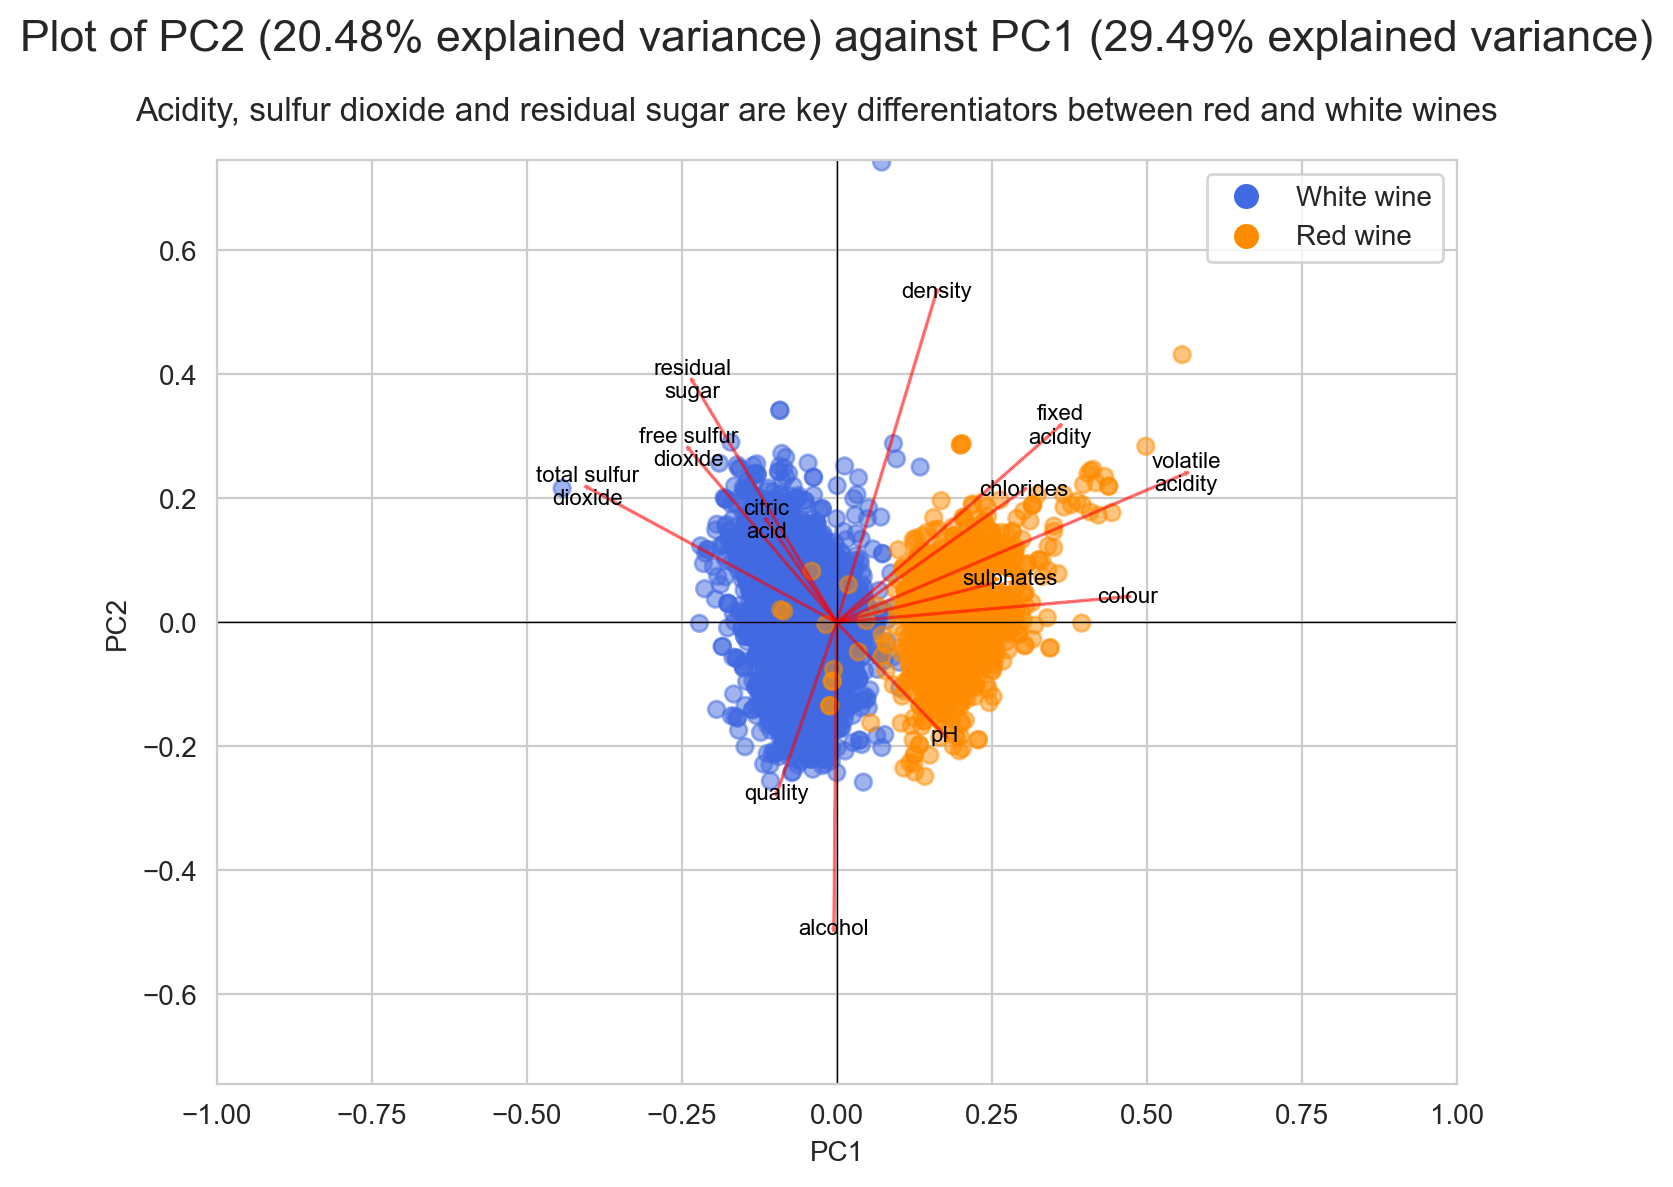

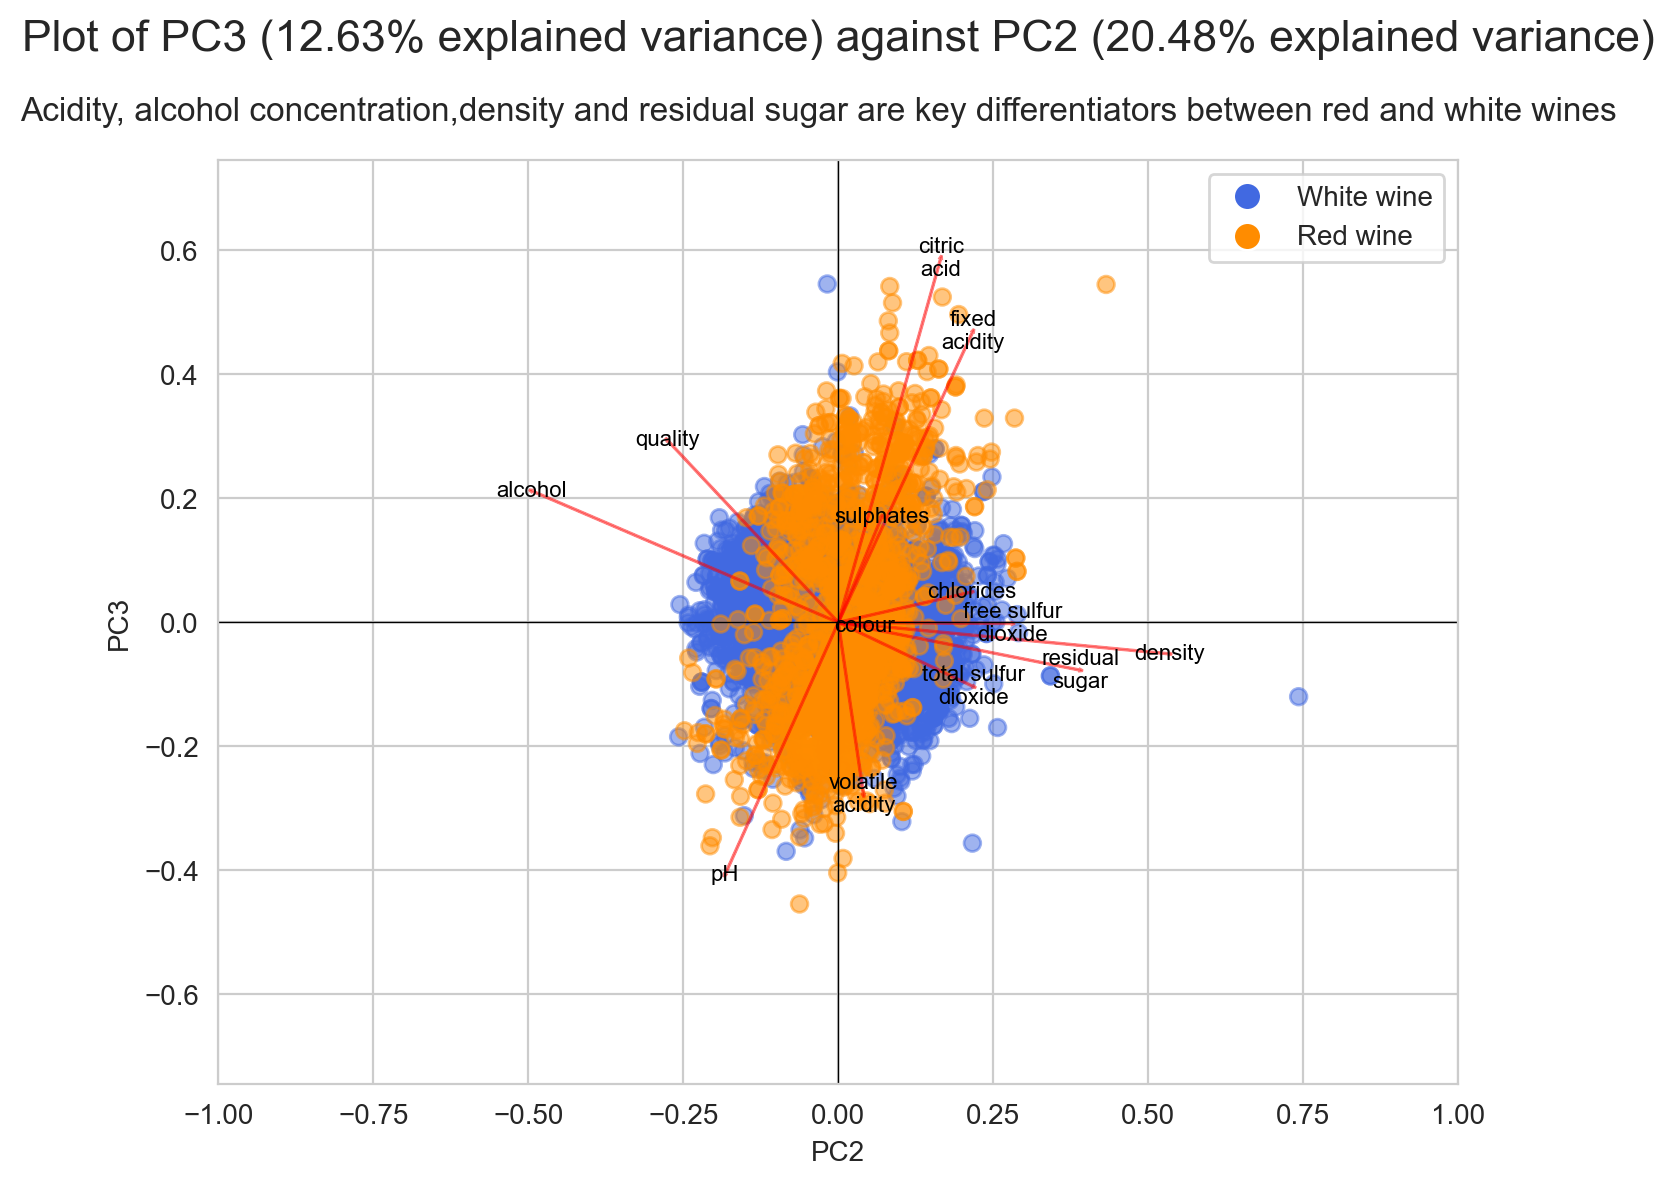

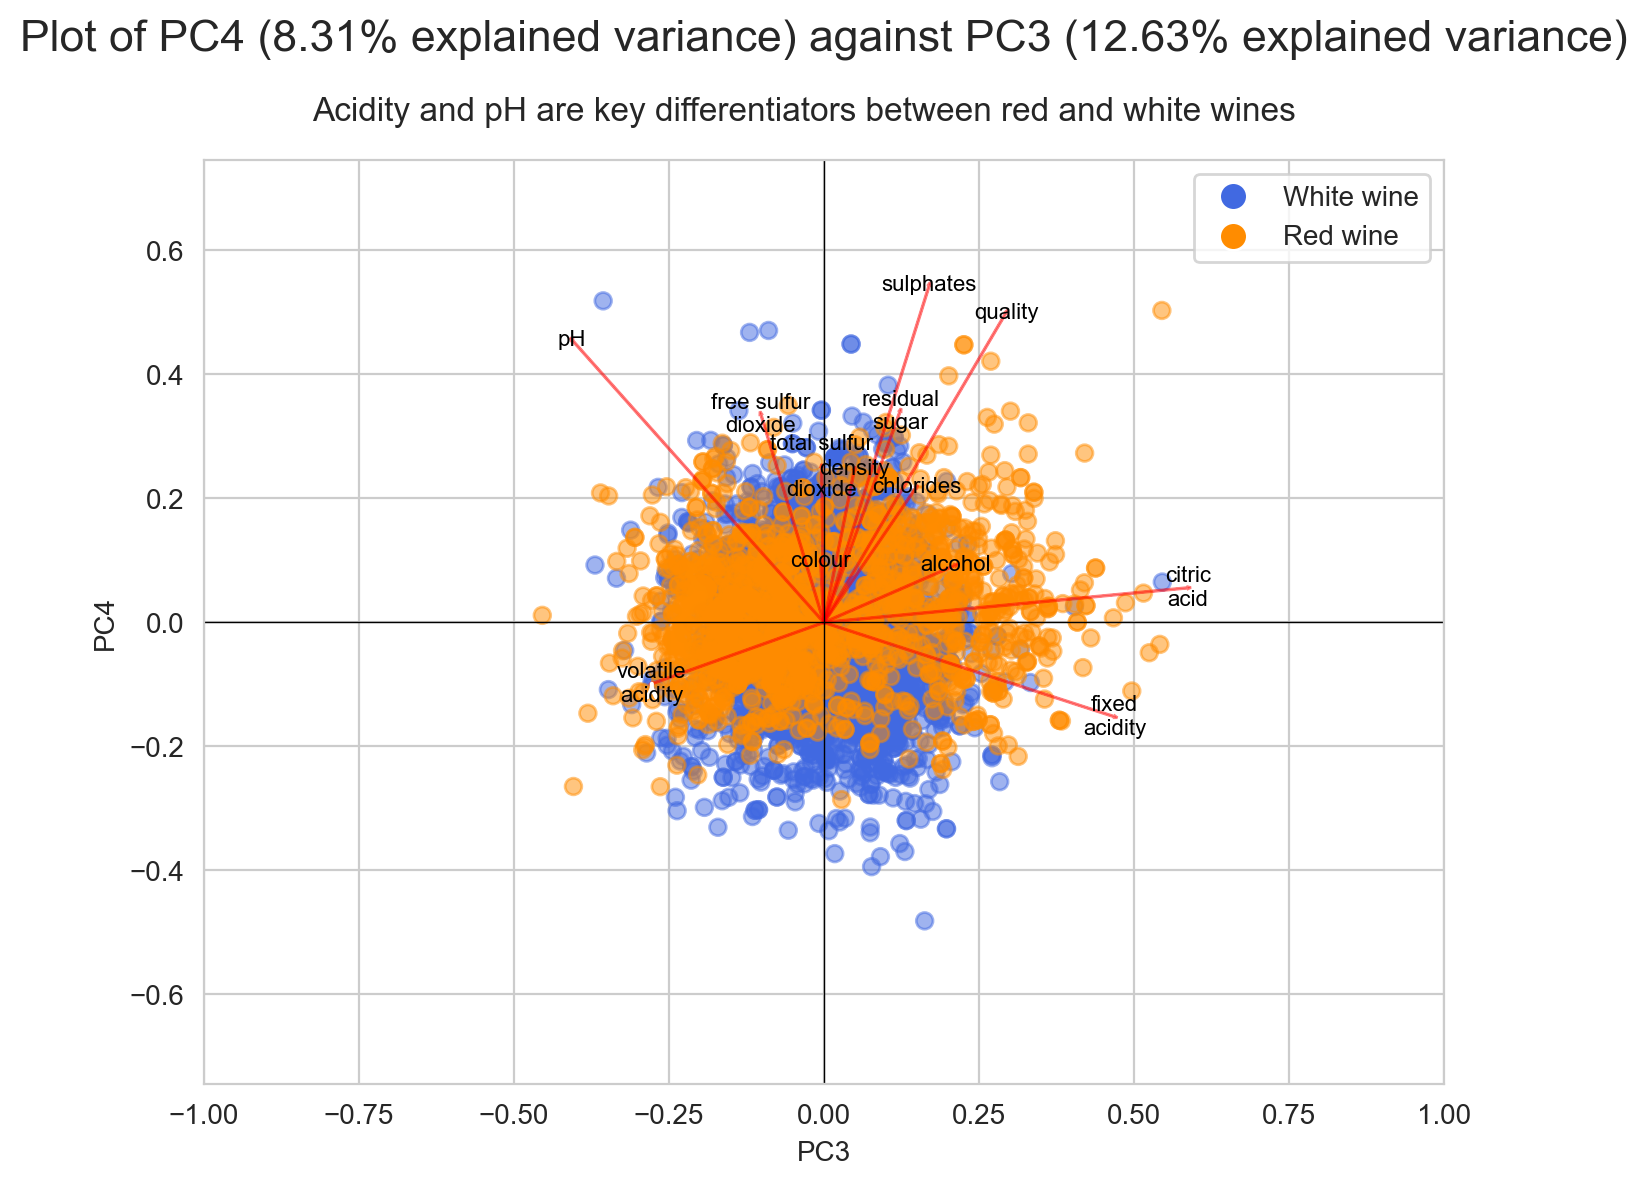

In [135]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'
plt.style.use('fast')

'''
A function to produce biplots for PCA components. Assumes data has already been fitted with a pipeline and is available as wine_data_all. Values for fit and pca are passed in because different scopes enforce the use of references and not modifying original fit
'''
def biplot_for_pca(pipeline_fit: object,pca_fit: PCA, pca_number_for_x_axis : int, pca_number_for_y_axis : int,plot_title: str,figure_file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8,6))
    ax.grid(True)
    plt.axis("equal")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC{pca_number_for_x_axis}")
    plt.ylabel(f"PC{pca_number_for_y_axis}")
    plt.title(plot_title, fontsize=16,y=1.1)
    
    # Extract transformed values from fit for x and y axes
    pca_data_index_x = pca_number_for_x_axis - 1
    pca_data_index_y = pca_number_for_y_axis - 1
    pca_data_x = pipeline_fit.transform(wine_data_all)[:,pca_data_index_x]
    pca_data_y = pipeline_fit.transform(wine_data_all)[:,pca_data_index_y]
    coeff = np.transpose(pca_fit.components_[pca_data_index_x:pca_number_for_y_axis,:])
    n=wine_data_all.shape[1]
    scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
    scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
    # Used for differentiating the wine type
    colour_mapping = {0: "royalblue", 1: "darkorange"}
    ax.scatter(x=pca_data_x*scale_x_axis,y=pca_data_y*scale_y_axis, c=wine_data_all['colour'].map(colour_mapping),alpha=0.5)
    # Generate the legend
    legend_labels = ["White wine", "Red wine"]
    # Make a point with no data, modifying it to display a legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colour_mapping[i], markersize=10) for i in range(2)]
    ax.legend(legend_handles, legend_labels, loc='upper right')
    for column_index in range(n):
        x_position = coeff[column_index, 0]
        y_position = coeff[column_index, 1]
    
        # Check if the label will overlap with others, and adjust position if needed
        if column_index < n - 1:
            for j in range(column_index + 1, n):
                if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                    x_position += 0.1
                    y_position += 0.1
    
        label = wine_data_all.T.index[column_index]
    
        # Find the last space character and replace it with a newline
        last_space_index = label.rfind(" ")
        if last_space_index >= 0:
            # Add an extra new line for total sulfur dioxide so labels don't overlap
            if pca_number_for_y_axis == 4 and column_index == 6:
                label = label[:last_space_index] + "\n\n" + label[last_space_index+1:]
            label = label[:last_space_index] + "\n" + label[last_space_index+1:]
    
        ax.arrow(0, 0, x_position, y_position, color="r", alpha=0.5)
        # Add arrowheads to labels
        ax.annotate(label, (x_position, y_position), color="black",
                     arrowprops=dict(arrowstyle="->", lw=1.5),
                     fontsize=8, ha='center', va='center')

    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line
    match pca_number_for_x_axis:
        case 1:
            plt.text(0.5, 0.92,"Acidity, sulfur dioxide and residual sugar are key differentiators between red and white wines",fontsize=12, ha='center', va='center', transform=plt.gcf().transFigure)
        case 2:
            plt.text(0.5, 0.92,"Acidity, alcohol concentration,density and residual sugar are key differentiators between red and white wines",fontsize=12, ha='center', va='center', transform=plt.gcf().transFigure)
        case 3:
            plt.text(0.5, 0.92,"Acidity and pH are key differentiators between red and white wines", fontsize=12, ha='center', va='center', transform=plt.gcf().transFigure)

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')
# PCA numbers are between 1 and 4, so we just need range 1 to 3, with 4 being 3 + 1.  
explained_variance_percentage = ["{:.2%}".format(num) for num in pca.explained_variance_ratio_]
for pca_number in range(1,4):
    # Create a new PCA object for each plot
    biplot_for_pca(fit, pca,pca_number,pca_number+1,f"Plot of PC{pca_number+1} ({explained_variance_percentage[pca_number]} explained variance) against PC{pca_number} ({explained_variance_percentage[pca_number-1]} explained variance)",f"pc{pca_number+1}_vs_pc{pca_number}")
    

In [6]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [19]:
wine_data_all.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'colour'],
      dtype='object')

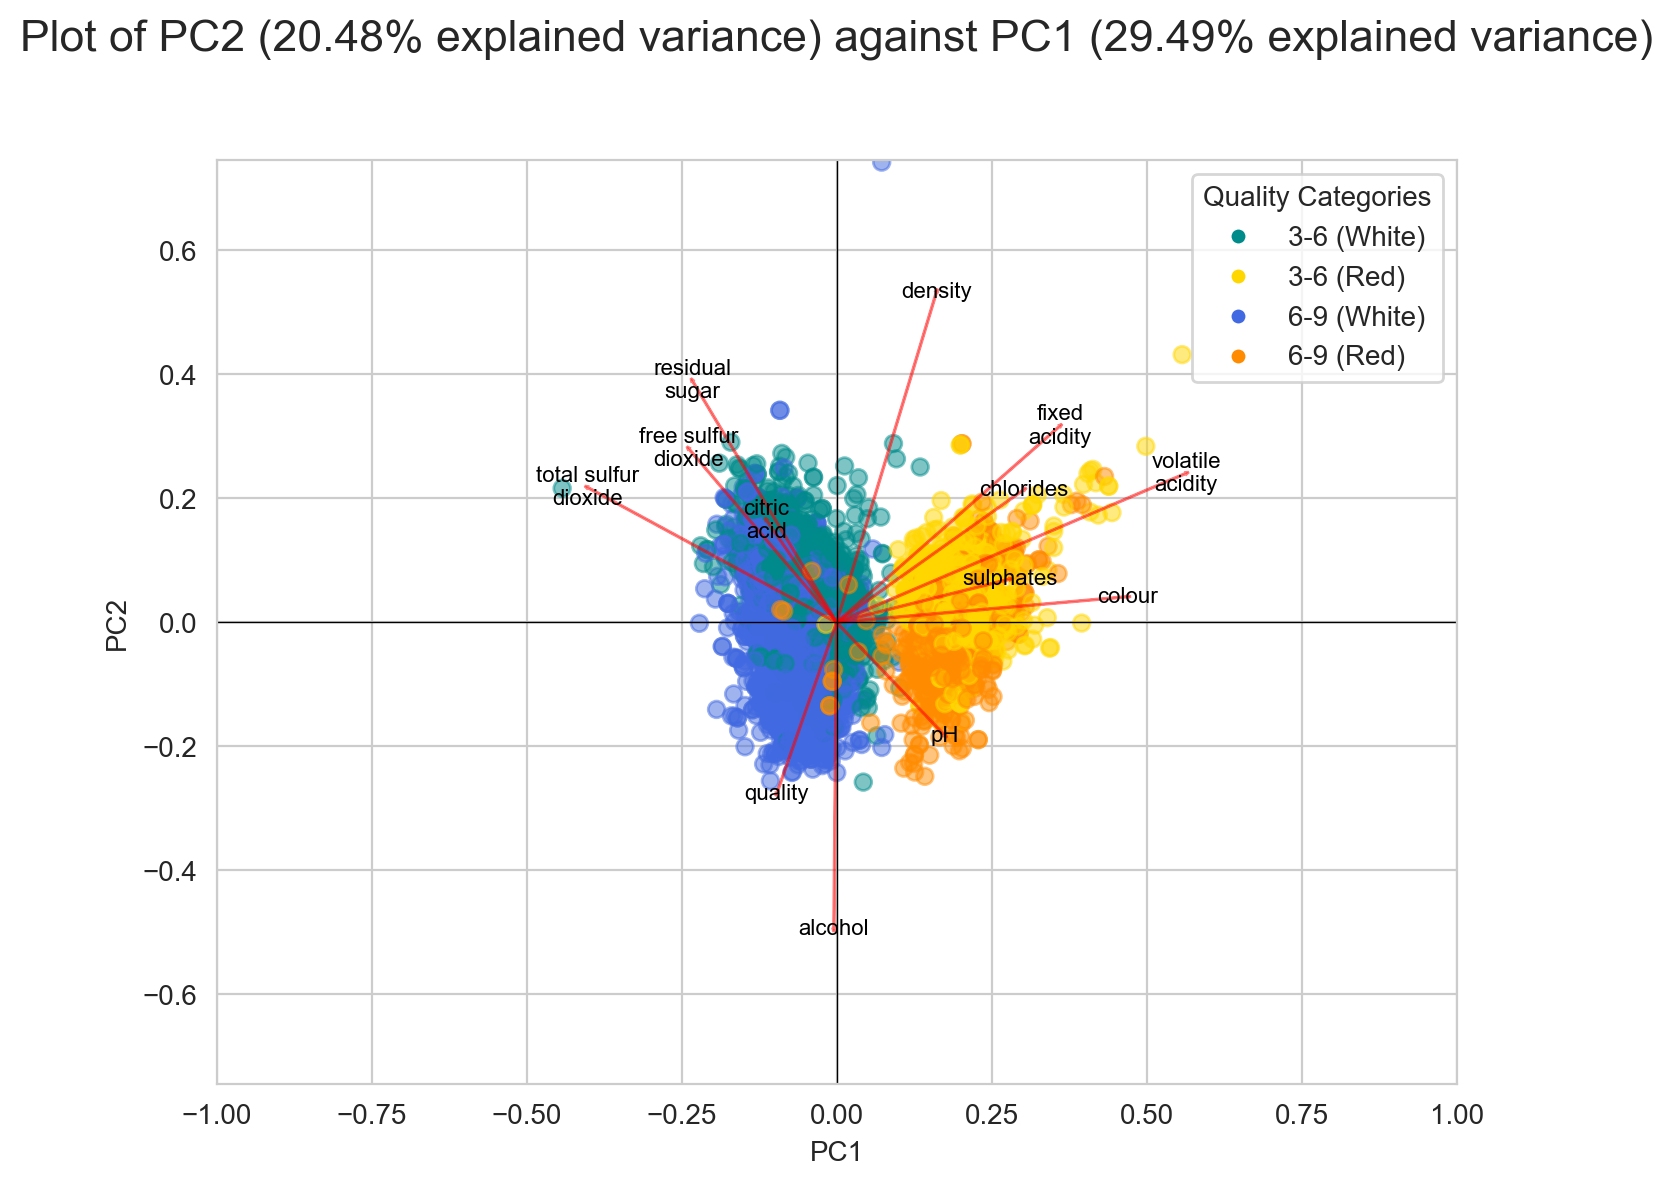

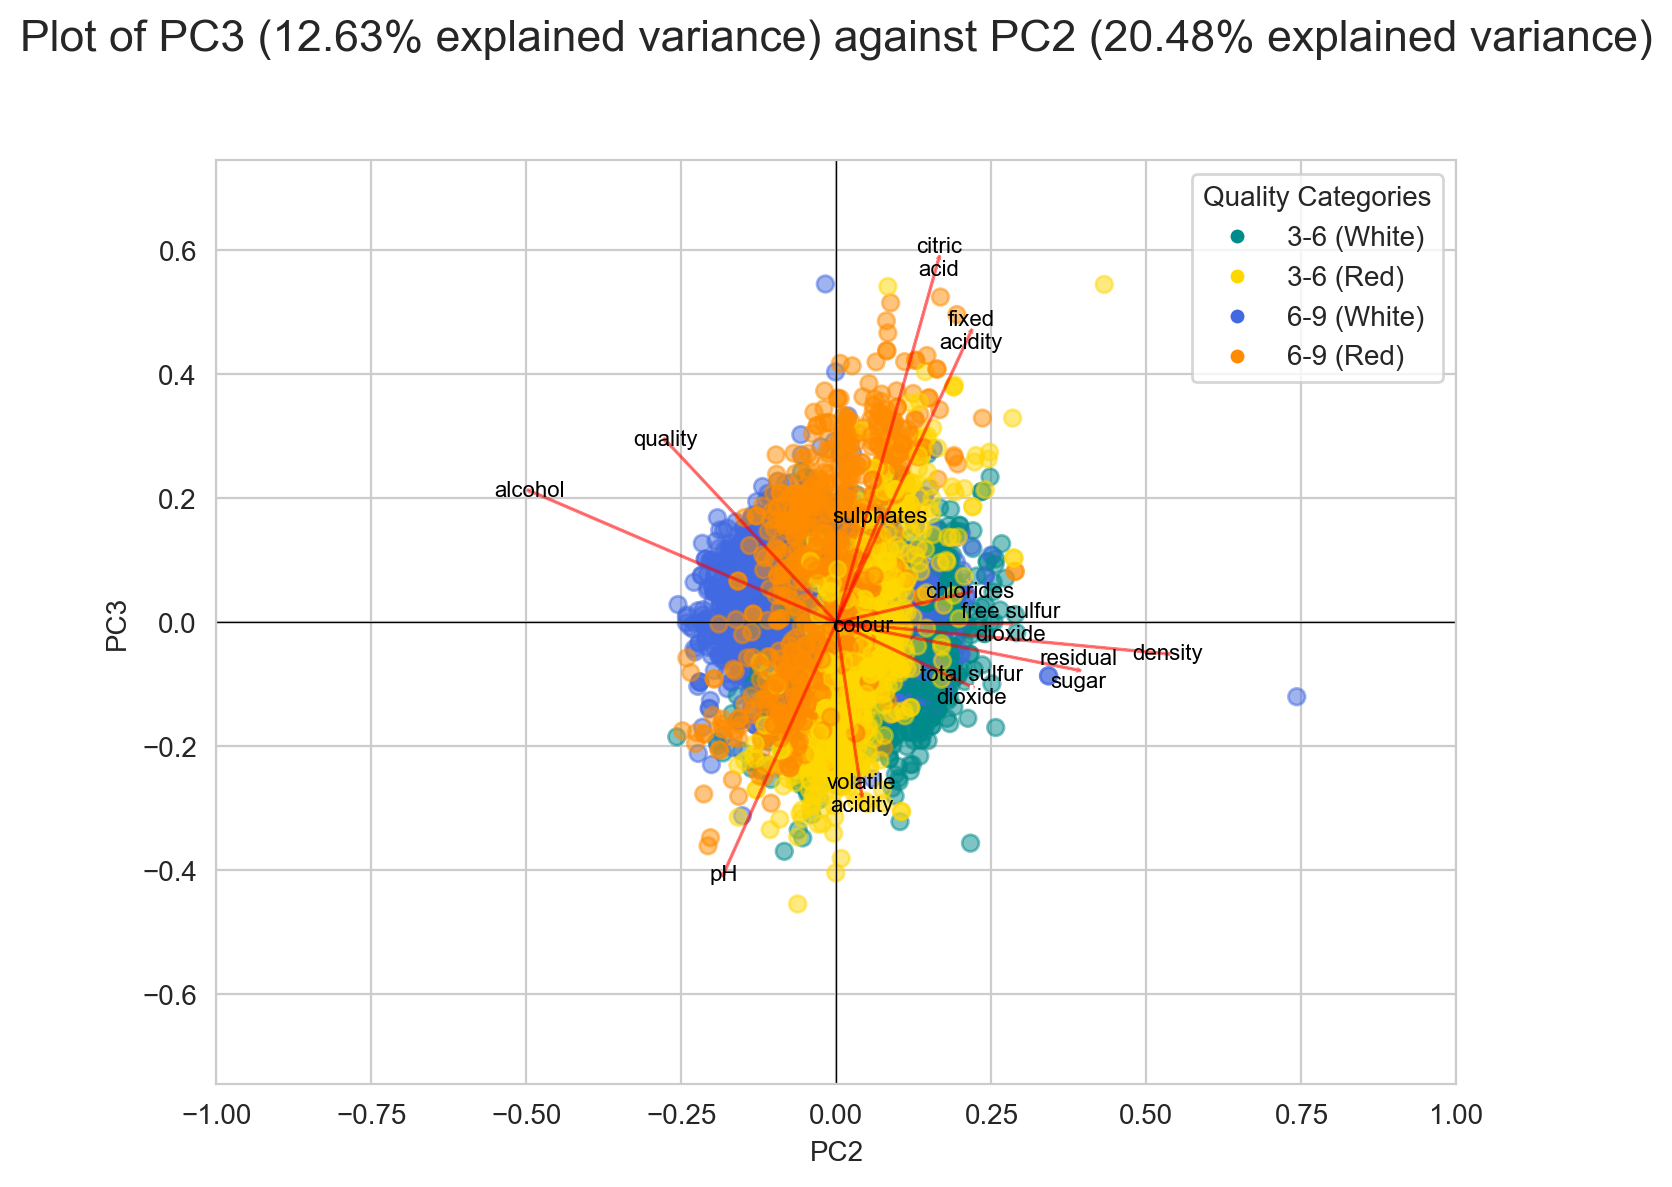

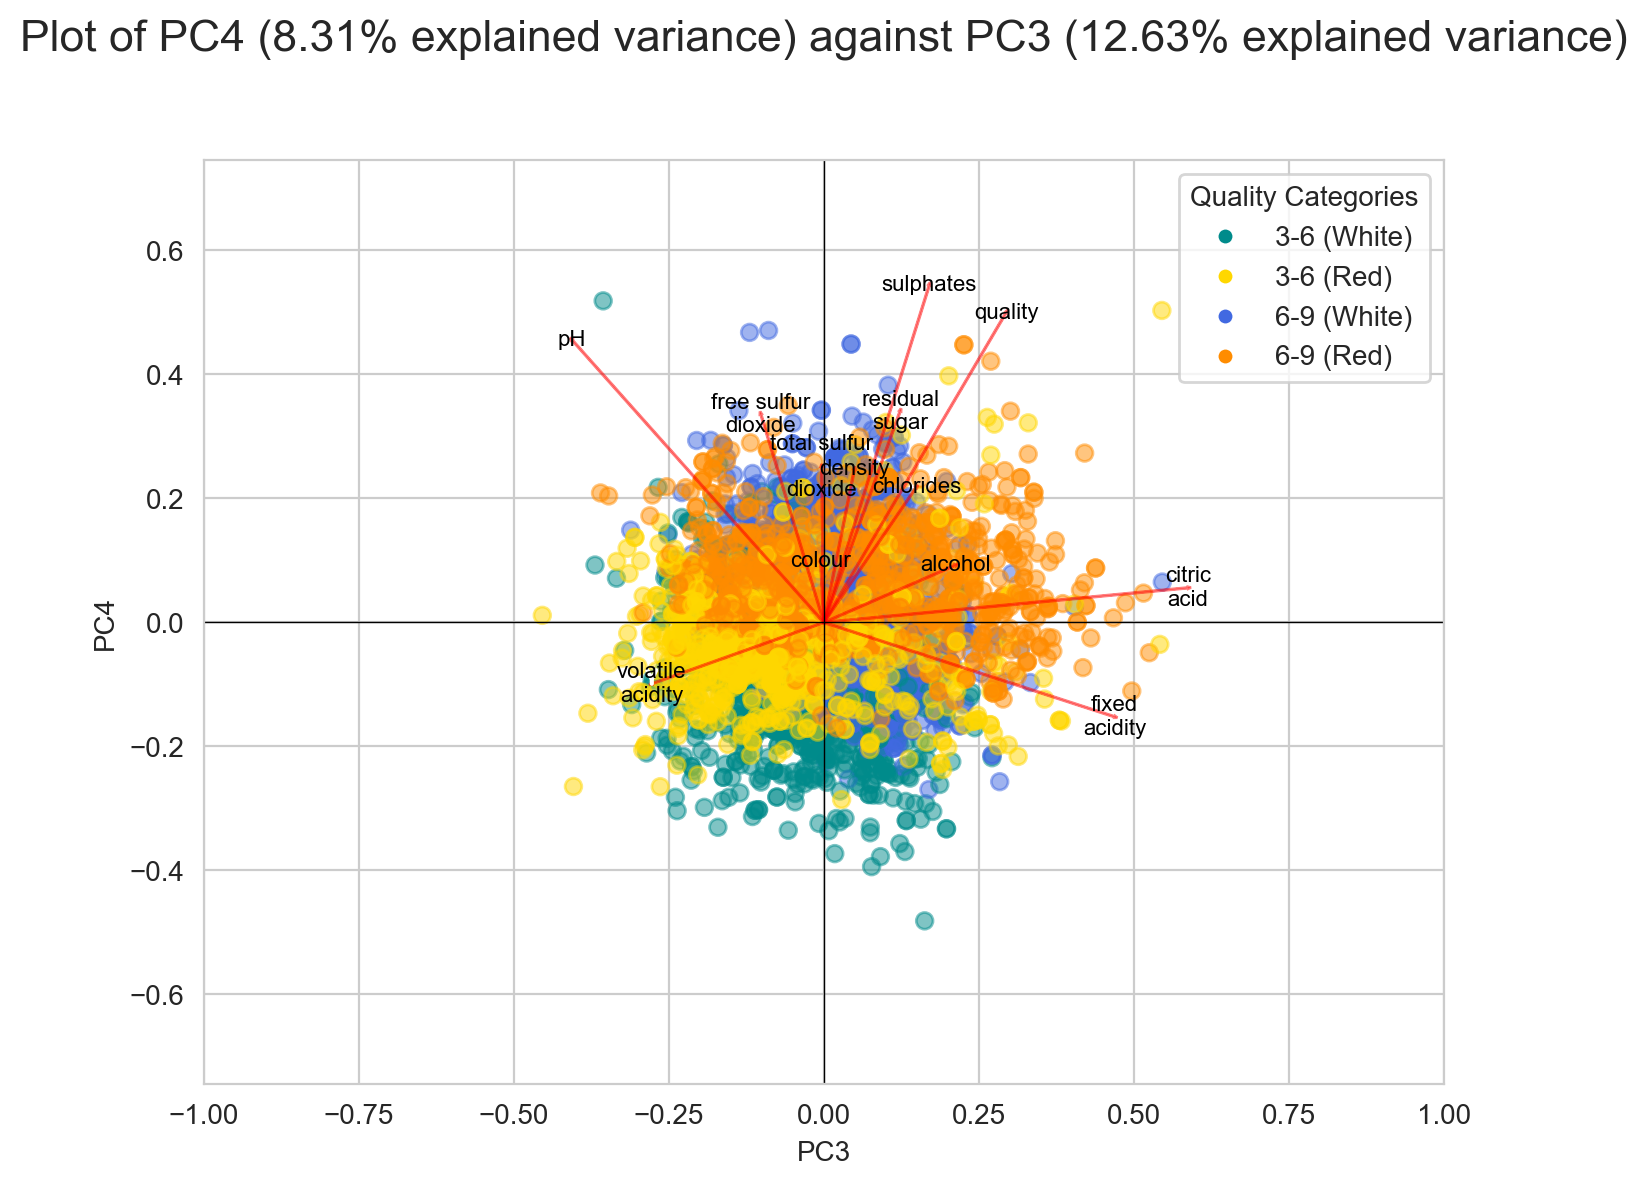

In [136]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

%matplotlib inline

# Define quality categories and corresponding colors
quality_categories = ['3-6 white', '3-6 red', '6-9 white', '6-9 red']
category_colors = {'3-6 white': 'darkcyan', '3-6 red': 'gold', '6-9 white': 'royalblue', '6-9 red': 'darkorange'}


def biplot_for_pca_quality(pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_title: str, figure_file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True)
    plt.axis("equal")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC{pca_number_for_x_axis}")
    plt.ylabel(f"PC{pca_number_for_y_axis}")
    plt.title(plot_title, fontsize=16, y=1.1)
    
    # Create a new column based on conditions
    data_copy = deepcopy(wine_data_all)
    # Define conditions
    conditions = [
        (data_copy['quality'].ge(3) & data_copy['quality'].lt(6)),
        (data_copy['quality'].ge(6) & data_copy['quality'].le(9)),
    ]
    
    # Define corresponding categories
    categories = ['3-6', '6-9']
    
    # Use np.select to assign categories based on conditions
    data_copy['quality_category'] = np.select(conditions, categories, default='Unknown')
    data_copy['quality_categories_by_wine'] = np.where(
        (data_copy['colour'] == 0) & (data_copy['quality_category'] == '3-6'), '3-6 white',
        np.where(
            (data_copy['colour'] == 0) & (data_copy['quality_category'] == '6-9'), '6-9 white',
            np.where(
                (data_copy['colour'] == 1) & (data_copy['quality_category'] == '3-6'), '3-6 red', '6-9 red'
            )
        )
    )

    # Drop unnecessary columns
    data_copy = data_copy.drop(columns=['quality_category'])

    # Define the features to be scaled (excluding 'quality_categories_by_wine')
    features_to_scale = [col for col in data_copy.columns if col != 'quality_categories_by_wine']

    # Create a ColumnTransformer that applies StandardScaler to specified features
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), features_to_scale),
        ],
        remainder='passthrough'  # Pass through columns not specified in transformers
    )

    pca_new = PCA(n_components=4)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', pca_new)
    ])

    # Exclude 'quality_categories_by_wine' during fitting
    pipeline.fit(data_copy.drop(columns=['quality_categories_by_wine']))

    transformed_data = pipeline.transform(data_copy.drop(columns=['quality_categories_by_wine']))

    # Extract transformed values from fit for x and y axes
    pca_data_index_x = pca_number_for_x_axis - 1
    pca_data_index_y = pca_number_for_y_axis - 1
    pca_data_x = transformed_data[:, pca_data_index_x]
    pca_data_y = transformed_data[:, pca_data_index_y]
    # Extract the components from the pipeline
    components = pipeline.named_steps['pca'].components_
    coeff = np.transpose(components[pca_data_index_x:pca_number_for_y_axis, :])
    n = data_copy.shape[1]
    scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
    scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
    # Your existing scatter plot code
    scatter = ax.scatter(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis,c=data_copy['quality_categories_by_wine'].map(category_colors) ,alpha=0.5)


    legend_labels = [
        '3-6 (White)',
        '3-6 (Red)',
        '6-9 (White)',
        '6-9 (Red)'
    ]

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors[category],
                                 label=label) for category, label in zip(quality_categories, legend_labels)]
    ax.legend(handles=legend_handles, title='Quality Categories', loc='upper right')

    for column_index in range(min(n, len(coeff))):
        x_position = coeff[column_index, 0]
        y_position = coeff[column_index, 1]

        # Check if the label will overlap with others, and adjust position if needed
        if column_index < n - 1:
            for j in range(column_index + 1, min(n, len(coeff))):
                if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                    x_position += 0.1
                    y_position += 0.1

        label = data_copy.T.index[column_index]

        # Find the last space character and replace it with a newline
        last_space_index = label.rfind(" ")
        if last_space_index >= 0:
            # Add an extra new line for total sulfur dioxide so labels don't overlap
            if pca_number_for_y_axis == 4 and column_index == 6:
                label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
            label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

        ax.arrow(0, 0, x_position, y_position, color="r", alpha=0.5)
        # Add arrowheads to labels
        ax.annotate(label, (x_position, y_position), color="black",
                     arrowprops=dict(arrowstyle="->", lw=1.5),
                     fontsize=8, ha='center', va='center')

    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

# Outside the function
for pca_number in range(1, 4):
    # Create a new PCA object for each plot
    pca_new = PCA(n_components=4)

    # Call the function with the specific PCA object
    biplot_for_pca_quality(fit, pca_new, pca_number, pca_number + 1,
                           f"Plot of PC{pca_number + 1} ({explained_variance_percentage[pca_number]} explained variance) against PC{pca_number} ({explained_variance_percentage[pca_number - 1]} explained variance)",
                           f"wine_quality_pc{pca_number + 1}_vs_pc{pca_number}")


In [91]:
print(wine_data_all['quality'].unique())

[6 5 7 8 4 3 9]
